In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scienceplots
from tqdm import tqdm
import time

plt.style.use(['science', 'ieee'])
torch.manual_seed(1024)

k = 400 # spring constant (N/m)
c = 4 # damping constant (N.s/m)
m = 1 # load mass (kg)
# F = 0 # external force (N)

def exact_function(t):
    d = c / (2 * m)
    w0 = np.sqrt(k / m)

    # x(t) = exp^(-d * t) * (2A * cos(phi + w * t))
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1 / (2 * np.cos(phi))
    x = (np.exp(-d * t)) * (2 * A * np.cos(phi + w * t))
    return x

# DATA PROCESSING
# boundary timeline
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)

# physics timeline
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# dataset train/test
t_train = torch.linspace(0, 0.25, 30).view(-1, 1).requires_grad_(True)
x_train = torch.tensor(exact_function(t_train.detach().numpy())).view(-1, 1).requires_grad_(True)
t_test = torch.linspace(0, 1, 1200).view(-1, 1).requires_grad_(True)
x_test = torch.tensor(exact_function(t_test.detach().numpy())).view(-1, 1).requires_grad_(True)

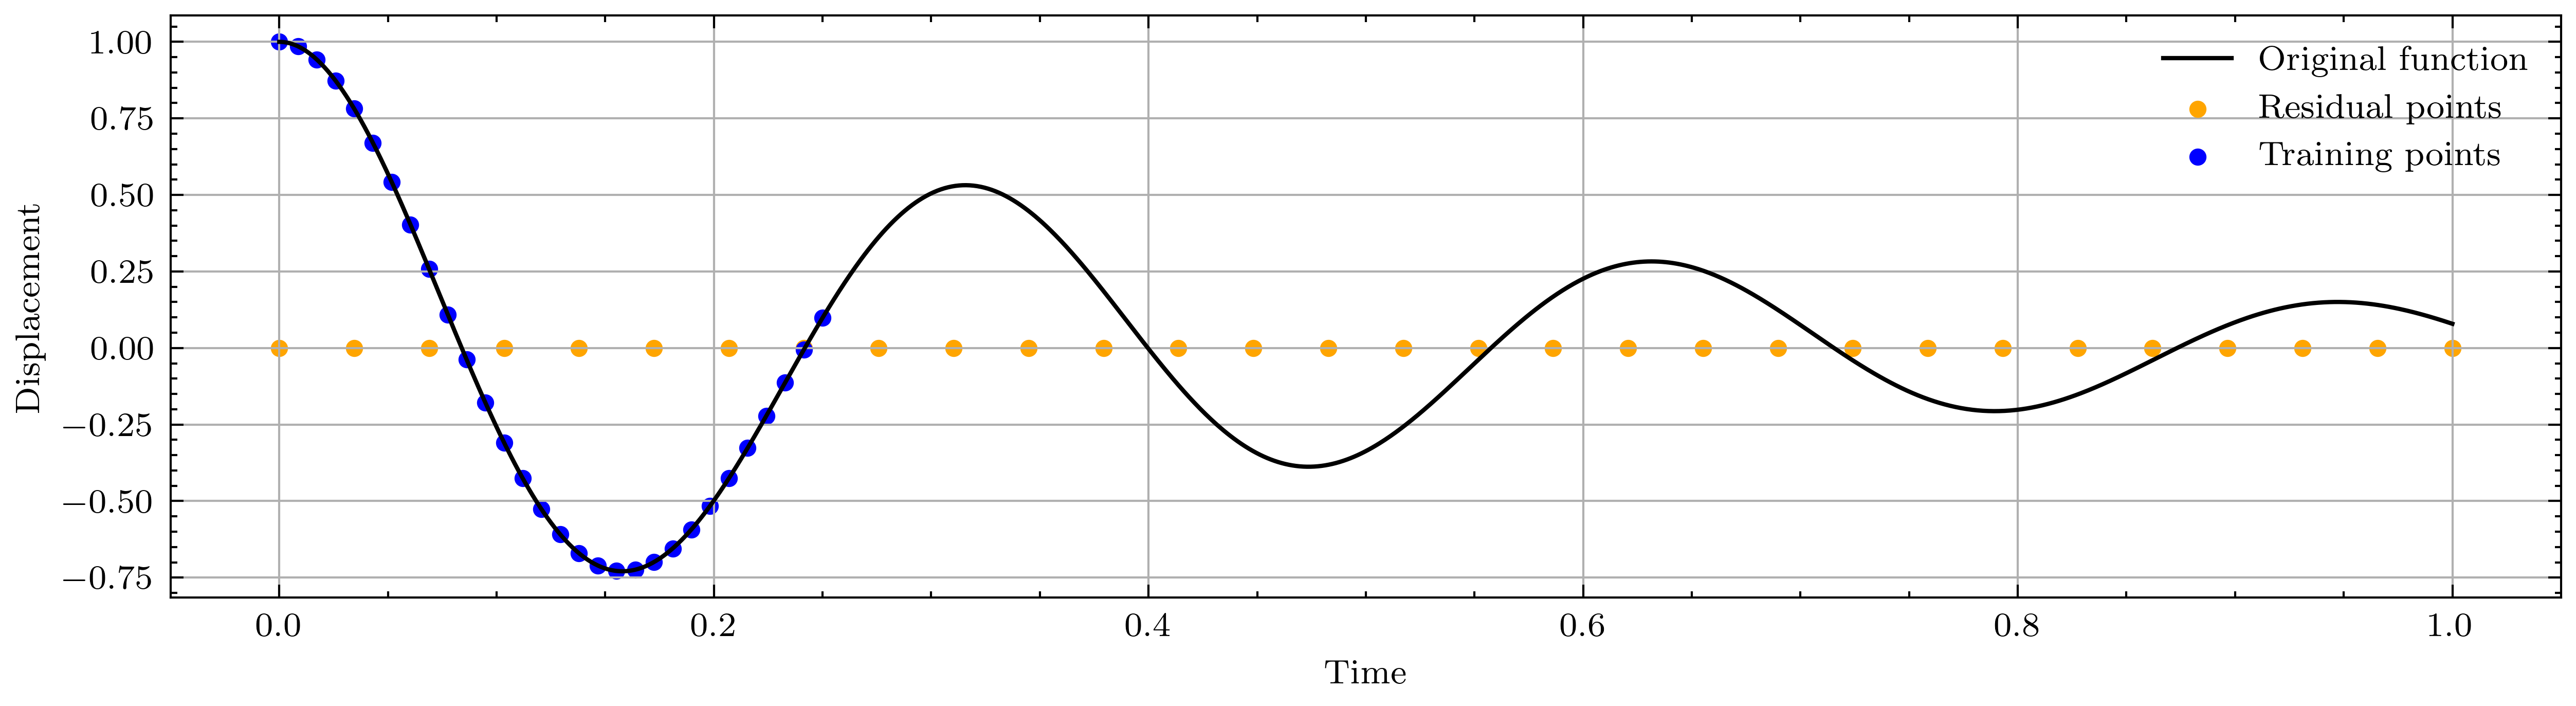

In [2]:
# Plot the original function and the predicted function
fig, ax = plt.subplots(figsize=(10, 2.5))
ax.plot(t_test.detach().numpy(), x_test.detach().numpy(), label='Original function')
ax.scatter(t_physics.detach().numpy(), torch.zeros_like(t_physics).detach().numpy(), label='Residual points', color='orange', marker='.')
ax.scatter(t_train.detach().numpy(), x_train.detach().numpy(), label='Training points', color='blue', marker='.')
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
plt.grid()
plt.legend()
plt.savefig("../figures/pinn/problem_statement.svg", format='svg', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
# Define the neural network model
class FCNN(nn.Module):
    '''
    Define neural network architecture
    '''
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN), activation()
        ])
        
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN), activation()
            ]) for _ in range(N_LAYERS)
        ])
        
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


def loss_calc(model, criterion):
    # loss weights
    lam1, lam2 = 1e-1, 1e-4

    # general loss
    x_pred = model(t_train)
    loss1 = criterion(x_pred, x_train)

    # boundary loss
    x_pred = model(t_boundary)
    loss2 = criterion(x_pred, torch.ones_like(x_pred))
    dxdt = torch.autograd.grad(x_pred, t_boundary, torch.ones_like(x_pred), create_graph=True)[0]
    loss3 = criterion(dxdt, torch.zeros_like(dxdt))

    # physics loss
    x_pred = model(t_physics)
    dxdt = torch.autograd.grad(x_pred, t_physics, torch.ones_like(x_pred), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt, t_physics, torch.ones_like(dxdt), create_graph=True)[0]
    h = (m * d2xdt2 + c * dxdt + k * x_pred)
    loss4 = criterion(h, torch.zeros_like(h))

    final_loss = loss2 + lam1 * loss3 + lam2 * loss4
    
    return final_loss


In [4]:
model = FCNN(1, 1, 32, 8)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define early stopping parameters
patience = 1000  # Number of epochs to wait for loss improvement
best_loss = float("inf")
counter = 0

# Train the neural network
loss_curve = {
    "epoch": [],
    "loss": [],
}

num_epochs = 200_000
pbar = tqdm(total=num_epochs, desc="Training Progress")
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    
    optimizer.zero_grad()

    loss = loss_calc(model, criterion)
    loss.backward()
    optimizer.step()

    loss_curve["epoch"].append(epoch)
    loss_curve["loss"].append(loss.item())

    # Check for loss improvement
    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0
    else:
        counter += 1

    # Check if early stopping criteria are met
    if counter >= patience:
        print(f'Early stopping at epoch {epoch+1} due to lack of loss improvement.')
        break

    # Update the progress bar description
    pbar.set_postfix({"Loss": loss.item()})
    pbar.update(1)

end_time = time.time()  # Stop the timer
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

model_path = f"../src/model/model_pinn.pt"
torch.save(model.state_dict(), model_path)
print("model saved!")

# model.load_state_dict(torch.load(model_path))
model.eval()
predictions = model(t_test)


Training Progress:   7%|▋         | 14051/200000 [05:14<48:27, 63.95it/s, Loss=0.0069]    

Early stopping at epoch 14052 due to lack of loss improvement.
Training time: 314.74 seconds
model saved!


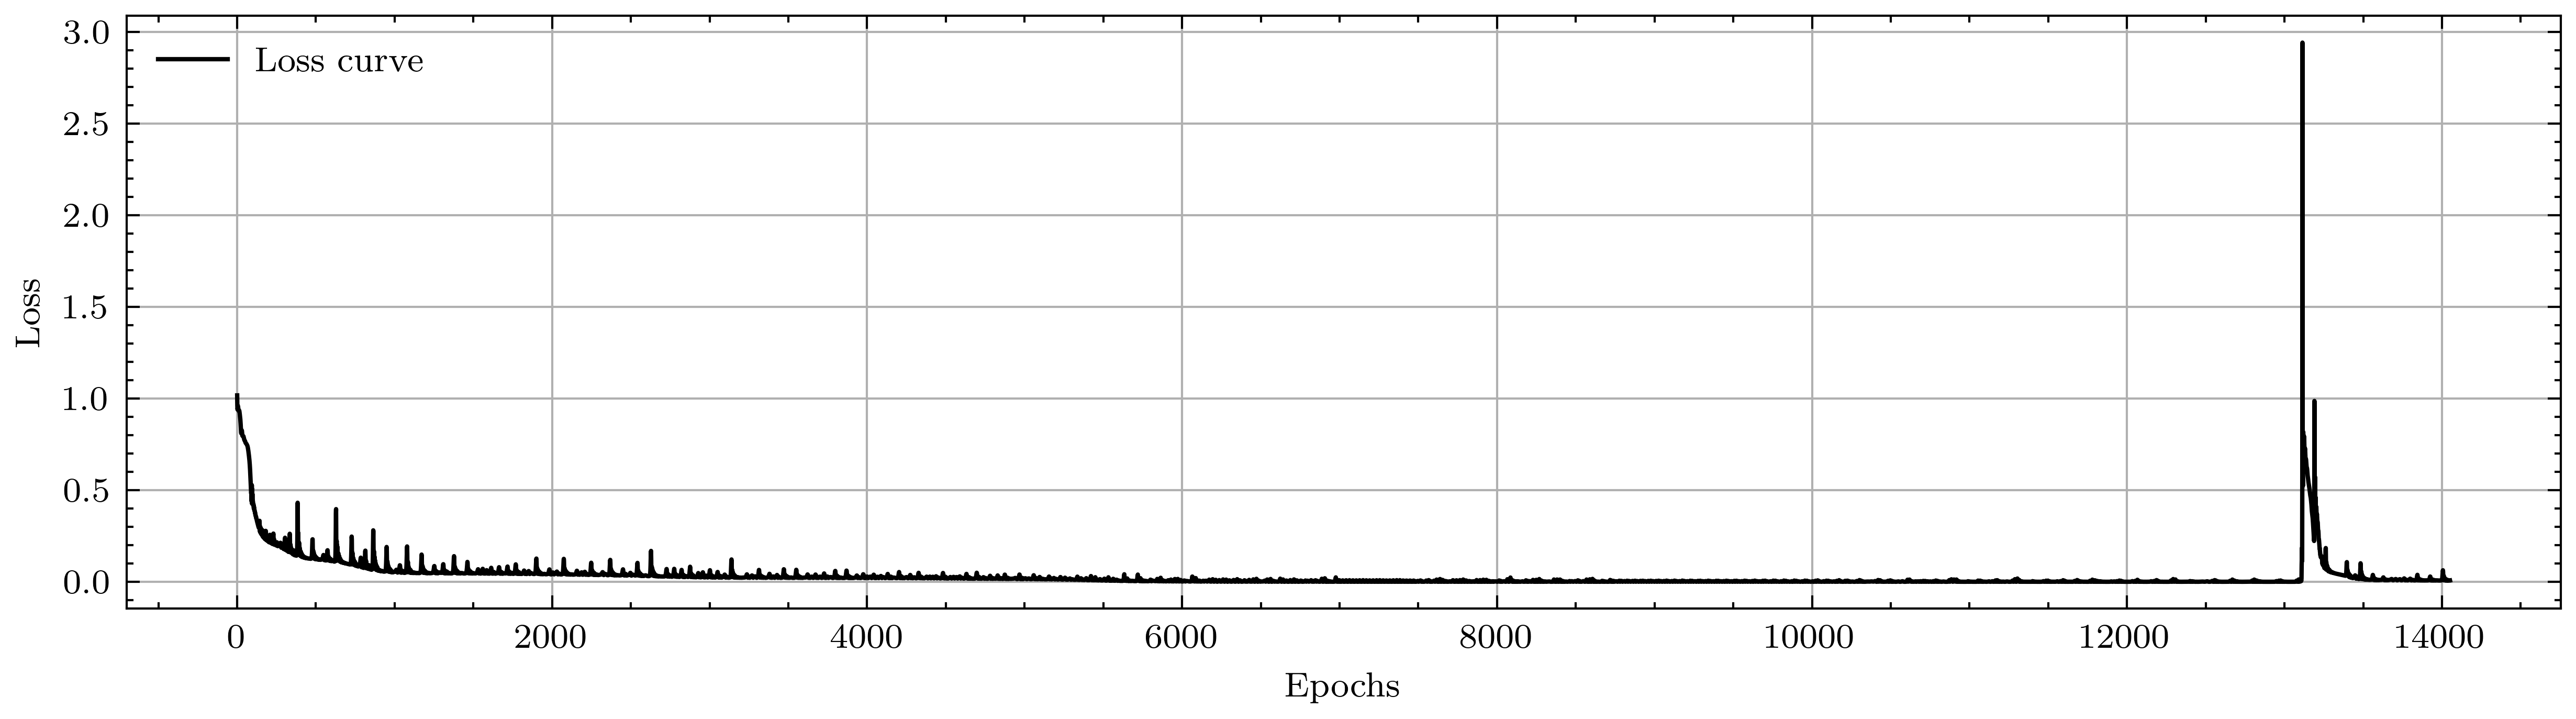

In [5]:
# Plot the loss curve
fig, ax = plt.subplots(figsize=(10, 2.5))
ax.plot(loss_curve['epoch'], loss_curve['loss'], label='Loss curve')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig("../figures/pinn/loss_curve.svg", format='svg', dpi=300, bbox_inches='tight')
plt.show()

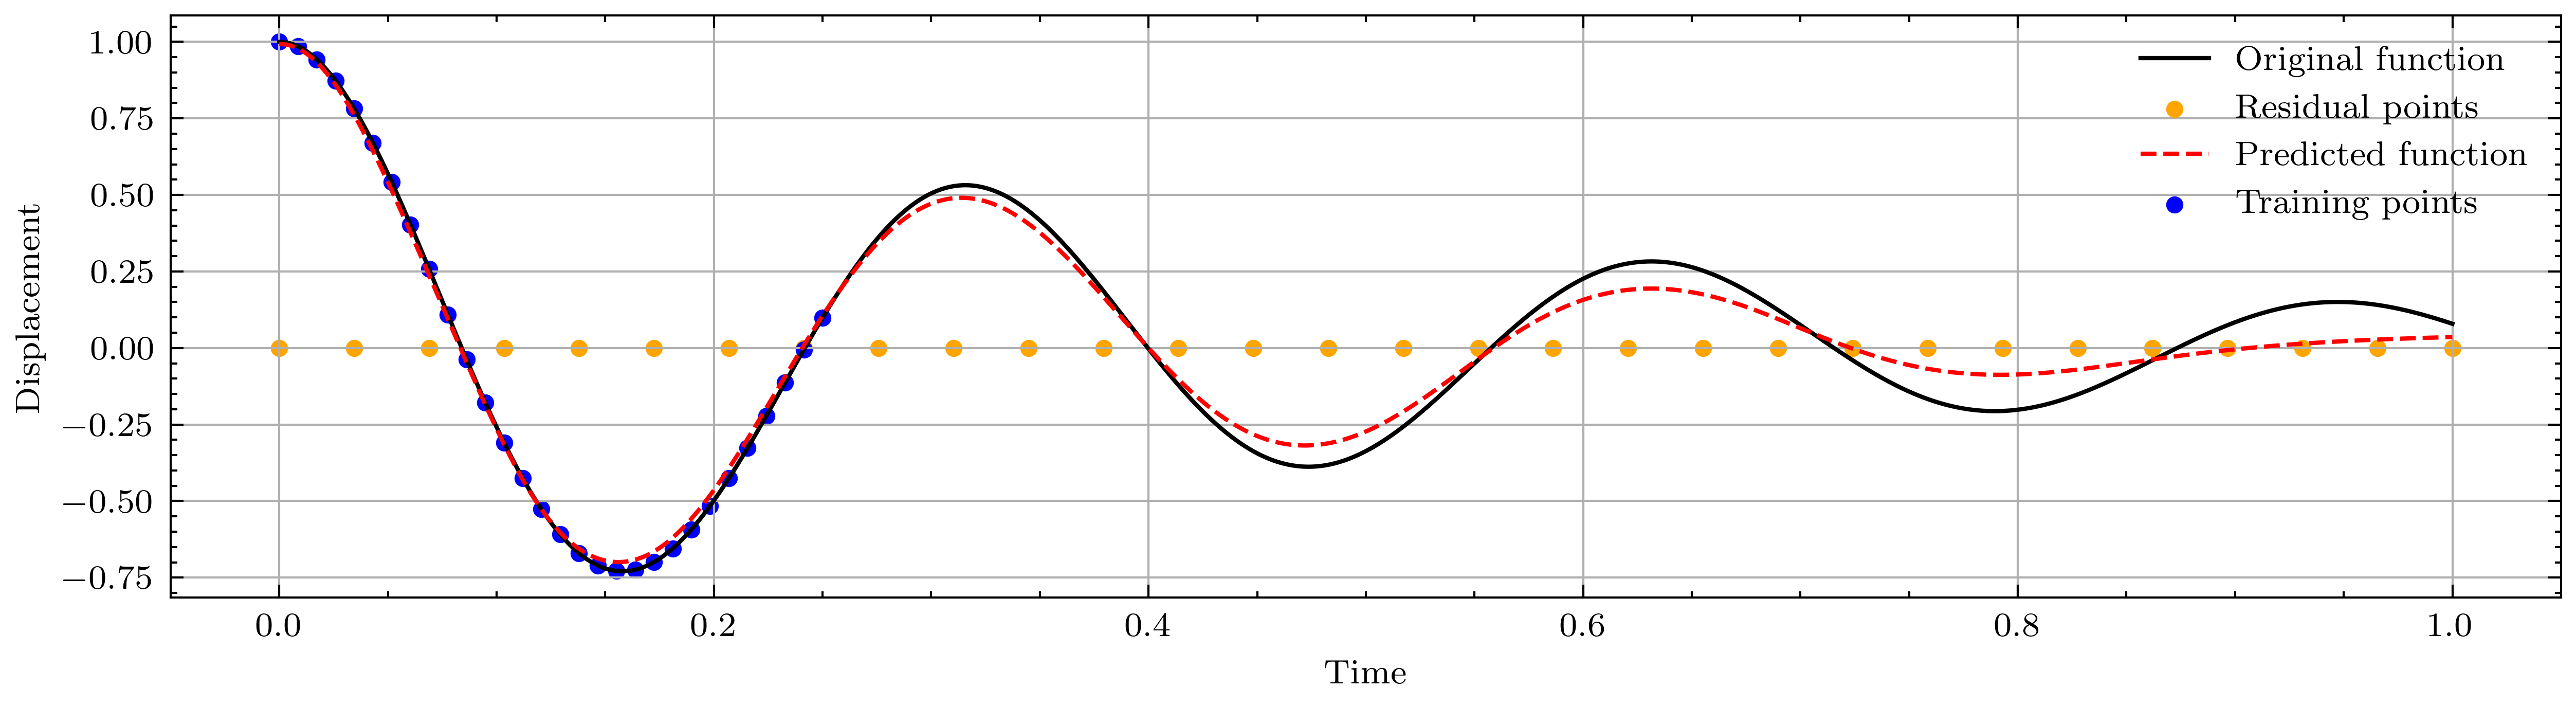

Training Progress:   7%|▋         | 14051/200000 [05:30<48:27, 63.95it/s, Loss=0.0069]

In [6]:
# Plot the original function and the predicted function
fig, ax = plt.subplots(figsize=(10, 2.5))
ax.plot(t_test.detach().numpy(), x_test.detach().numpy(), label='Original function')
ax.scatter(t_physics.detach().numpy(), torch.zeros_like(t_physics).detach().numpy(), label='Residual points', color='orange', marker='.')
ax.plot(t_test.detach().numpy(), predictions.detach().numpy(), label='Predicted function', color='red')
ax.scatter(t_train.detach().numpy(), x_train.detach().numpy(), label='Training points', color='blue', marker='.')
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
plt.grid()
plt.legend()
plt.savefig("../figures/pinn/final.svg", format='svg', dpi=300, bbox_inches='tight')
plt.show()